# Attention
https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing#scrollTo=hoelkOrFY8bN


In [23]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import torch
import torch.nn as nn
import math
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [24]:
# device = torch.device("cuda")
device = torch.device("cpu")


In [25]:
BatchSize = 32 # B
ContextLen = 8 # C
EmbeddingLen = 64 # E
HeadSize = EmbeddingLen // 4 # H
n_heads = 4

In [26]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(set(text))
vocab_size = len(chars)

string_to_int = {}
int_to_string = {}

for i,ch in enumerate(chars):
    int_to_string[i] = ch
    string_to_int[ch] = i

In [27]:
def encode(str_data):
    encoded_data = []
    for d in str_data:
        encoded_data.append(string_to_int[d])
    return encoded_data

In [28]:
data = torch.tensor( encode(text), dtype=torch.int ) 

In [29]:
def get_batch(data, context_len=ContextLen, batch_size = BatchSize):
    # B - batch size, C - context len
    idx_start = torch.randint(len(data) - context_len, (batch_size,))
    x_B_C = torch.stack([data[i:i+context_len] for i in idx_start])
    y_B_C = torch.stack([data[i+1:i+context_len+1] for i in idx_start])
    return x_B_C,y_B_C


In [30]:
class CausalSelfAttention(nn.Module):
    def __init__(self, head_size, emb_len):
        super().__init__()
        self.Query_matrix_E_H = nn.Linear(emb_len, head_size)
        self.Key_matrix_E_H = nn.Linear(emb_len, head_size)
        self.Value_matrix_E_H = nn.Linear(emb_len, head_size)
    
    def forward(self, x):
        # x is of shape B x C X E
        x_B_C_E = x
        query_vector_B_C_H = self.Query_matrix_E_H(x_B_C_E)
        key_vector_B_C_H = self.Key_matrix_E_H(x_B_C_E)
        value_vector_B_C_H = self.Value_matrix_E_H(x_B_C_E)

        attention_B_C_C = ((query_vector_B_C_H @ key_vector_B_C_H.transpose(-2, -1))/float(math.sqrt(HeadSize)))
        tril = torch.tril(torch.ones(ContextLen, ContextLen)).to(device)
        attention_B_C_C_inf = attention_B_C_C.masked_fill(tril == 0 ,float('-inf'))
        attention_softmax_B_C_C = F.softmax(attention_B_C_C_inf, dim = -1)
        value_with_attention_B_C_H = attention_softmax_B_C_C @ value_vector_B_C_H
        
        return value_with_attention_B_C_H
    
    


In [31]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size, emb_len):
        super().__init__()
        self.multiple_heads = nn.ModuleList([CausalSelfAttention(head_size, emb_len) for _ in range(num_heads)])
        self.proj = nn.Linear(emb_len, emb_len)

    def forward(self, x):
        multiple_heads_output_cat_B_C_E = torch.cat([single_head(x) for single_head in self.multiple_heads], dim=-1)
        proj_mult_head_B_C_E = self.proj(multiple_heads_output_cat_B_C_E)
        return proj_mult_head_B_C_E
        


In [32]:
class SingleBlock(nn.Module):
    def __init__(self, head_size, emb_len):
        super().__init__()
        self.embedding_matrix = nn.Embedding(vocab_size, emb_len)
        self.multiple_self_attention = MultiHeadAttention(n_heads,head_size, emb_len)
        self.feedforward = nn.Linear(emb_len, vocab_size)
        self.act = nn.ReLU()
        self.ln = nn.LayerNorm(emb_len)

    def forward(self, x):
        x_B_C_E = self.embedding_matrix(x)
        x_B_C_E = self.multiple_self_attention(x_B_C_E)
        x_B_C_E = self.ln(x_B_C_E)
        x_B_C_V = self.feedforward(x_B_C_E)
        x_B_C_V = self.act(x_B_C_V)
        return x_B_C_V


In [33]:
model = SingleBlock(HeadSize, EmbeddingLen)
model = model.to(device)

In [34]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

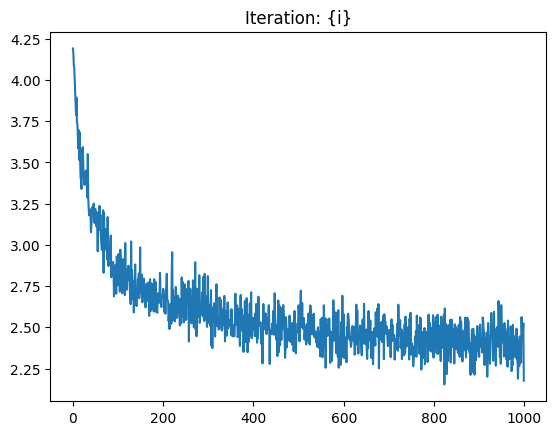

In [35]:
loss_arr = []
for i in range(1000):
    x,y =  get_batch(data)
    x = x.to(device)
    y = y.to(device)
    y = y.to(torch.long)

    model_output = model(x)
    B, C, V = model_output.shape

    model_output_reshaped = model_output.view(B*C, -1)
    y_output_reshaped = y.view(-1)
    loss = F.cross_entropy(model_output_reshaped, y_output_reshaped)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_arr.append(loss.item())
    clear_output(wait=True)
    plt.plot(loss_arr);plt.title('Iteration: {i}')
    plt.show()